In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams

import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv("NVDA.csv")
print(df.isna().sum())


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


Text(0, 0.5, 'Prices ($)')

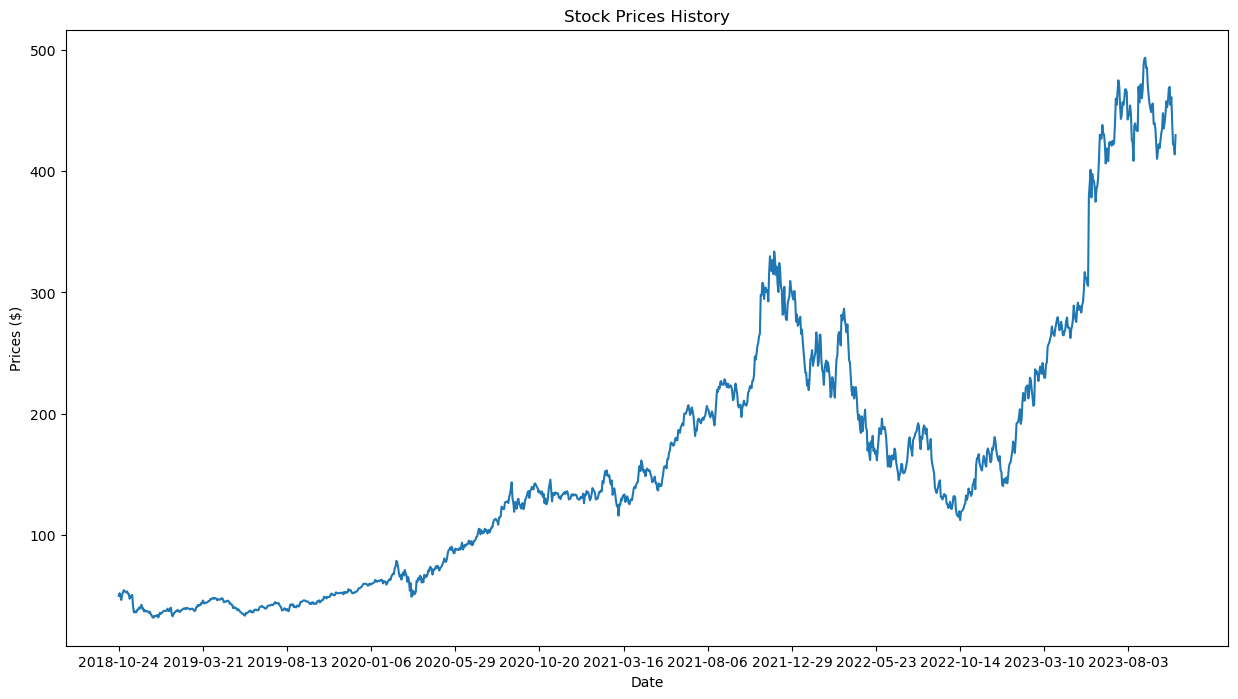

In [2]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(df.loc[:, 'Date'], df.loc[: , 'Close'])
plt.xticks(np.arange(0,1230,100))
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [3]:
# Converting the 'Date' from object time to the datetime format
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date', inplace=False)
print(df.tail())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-10-17  440.000000  447.540009  424.799988  439.380005  439.380005   
2023-10-18  425.910004  432.190002  418.250000  421.959991  421.959991   
2023-10-19  428.109985  432.970001  418.820007  421.010010  421.010010   
2023-10-20  418.899994  424.700012  410.779999  413.869995  413.869995   
2023-10-23  412.290009  432.480011  409.450012  429.750000  429.750000   

              Volume  
Date                  
2023-10-17  81233300  
2023-10-18  62729400  
2023-10-19  50123300  
2023-10-20  47638100  
2023-10-23  47721800  


We will use the Augmented Dickey-Fuller Test to determine if the data is stationary. 
<p> Null Hypothesis: Data is not stationary
<p> Alternative Hypothesis: Data is stationary
<p> We will only reject the null hypothesis if the p-value <= significance level of 0.05

In [4]:
# Augemented Dickey-Fuller Test
print('Results of Dickey-Fuller Test:')
dftest = adfuller(df['Close'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -0.047194
p-value                           0.954451
#Lags Used                       11.000000
Number of Observations Used    1245.000000
Critical Value (1%)              -3.435613
Critical Value (5%)              -2.863864
Critical Value (10%)             -2.568007
dtype: float64


As we can see, the p-value is 0.954451, meaning that the dtaa is likely not stationary. So we will use the ARIMA model which takes into account of the trend.

Use Auto ARIMA to find the suitable p, d, q values for the ARIMA model

In [5]:
# split into train and test sets, 80% for training, 20% for testing
train_set, test_set = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
print(test_set.index)

DatetimeIndex(['2022-10-21', '2022-10-24', '2022-10-25', '2022-10-26',
               '2022-10-27', '2022-10-28', '2022-10-31', '2022-11-01',
               '2022-11-02', '2022-11-03',
               ...
               '2023-10-10', '2023-10-11', '2023-10-12', '2023-10-13',
               '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19',
               '2023-10-20', '2023-10-23'],
              dtype='datetime64[ns]', name='Date', length=252, freq=None)


In [6]:
print(train_set.tail())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-10-14  120.570000  121.110001  112.040001  112.269997  112.201363   
2022-10-17  115.180000  119.480003  115.169998  118.879997  118.807320   
2022-10-18  123.440002  124.919998  116.180000  119.669998  119.596848   
2022-10-19  118.790001  123.500000  118.339996  120.510002  120.436340   
2022-10-20  121.129997  127.690002  121.050003  121.940002  121.865463   

              Volume  
Date                  
2022-10-14  71343200  
2022-10-17  58077400  
2022-10-18  65936200  
2022-10-19  52313100  
2022-10-20  65239800  


Performing stepwise search to minimize aic
 ARIMA(1,1,10)(0,0,0)[0] intercept   : AIC=6120.419, Time=2.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6116.153, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6115.851, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6115.715, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6114.354, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6117.379, Time=0.48 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.943 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1005
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3056.177
Date:                Tue, 23 Jan 2024   AIC                           6114.354
Time:                        11:18:29   BIC                           6119.266
Sample:                             0   HQIC                          6116.220
         

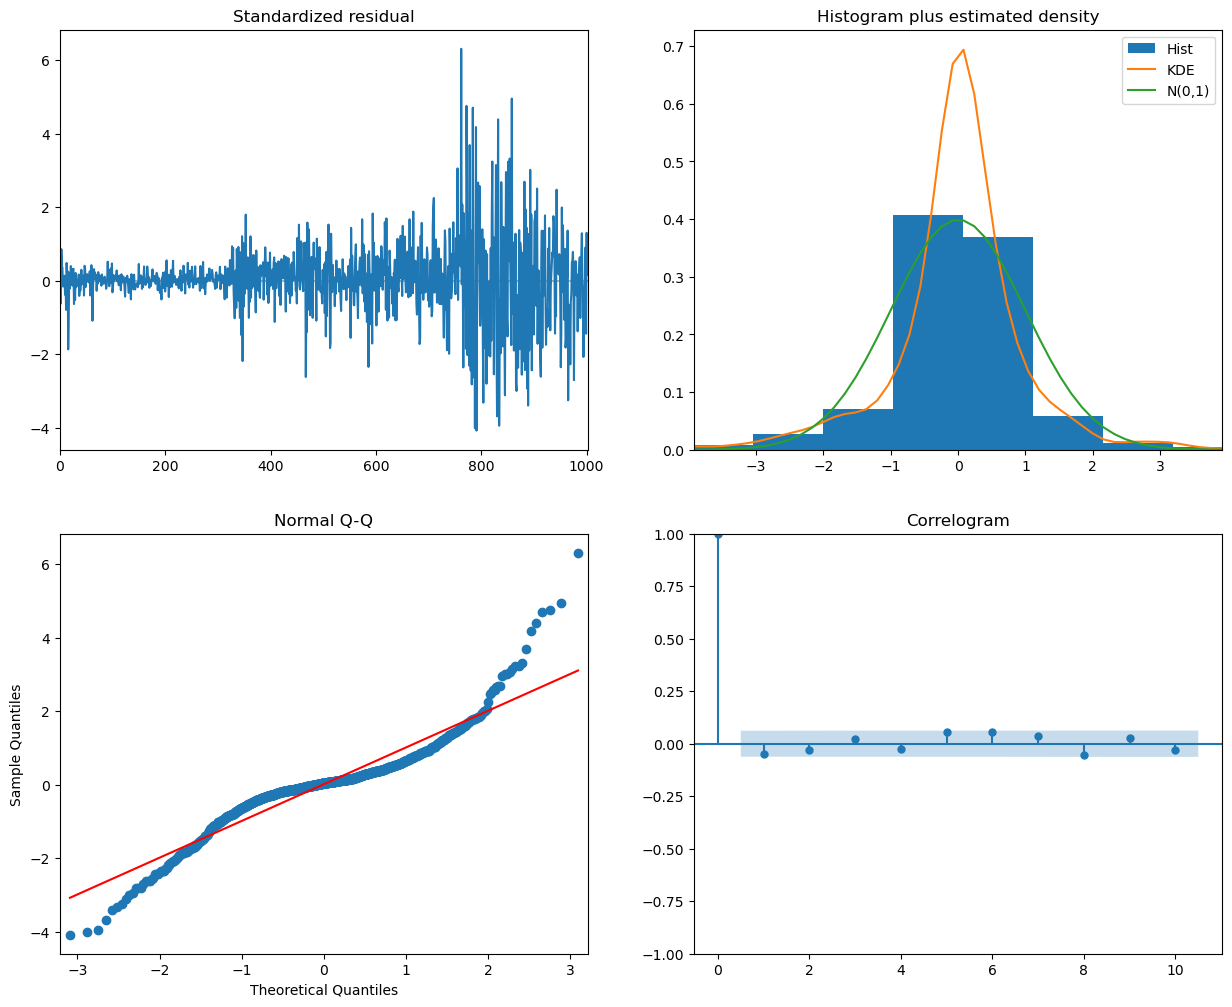

In [7]:
# ARIMA Model
ARIMA_model = pm.auto_arima(train_set['Close'], 
                      start_p=1, 
                      start_q=10,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=5, max_q=15, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      start_P=0,
                      D=0,
                      trace=True, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

print(ARIMA_model.summary())
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

c:\Users\HCM\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HCM\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1005    121.940002
1006    121.940002
1007    121.940002
1008    121.940002
1009    121.940002
           ...    
1252    121.940002
1253    121.940002
1254    121.940002
1255    121.940002
1256    121.940002
Length: 252, dtype: float64


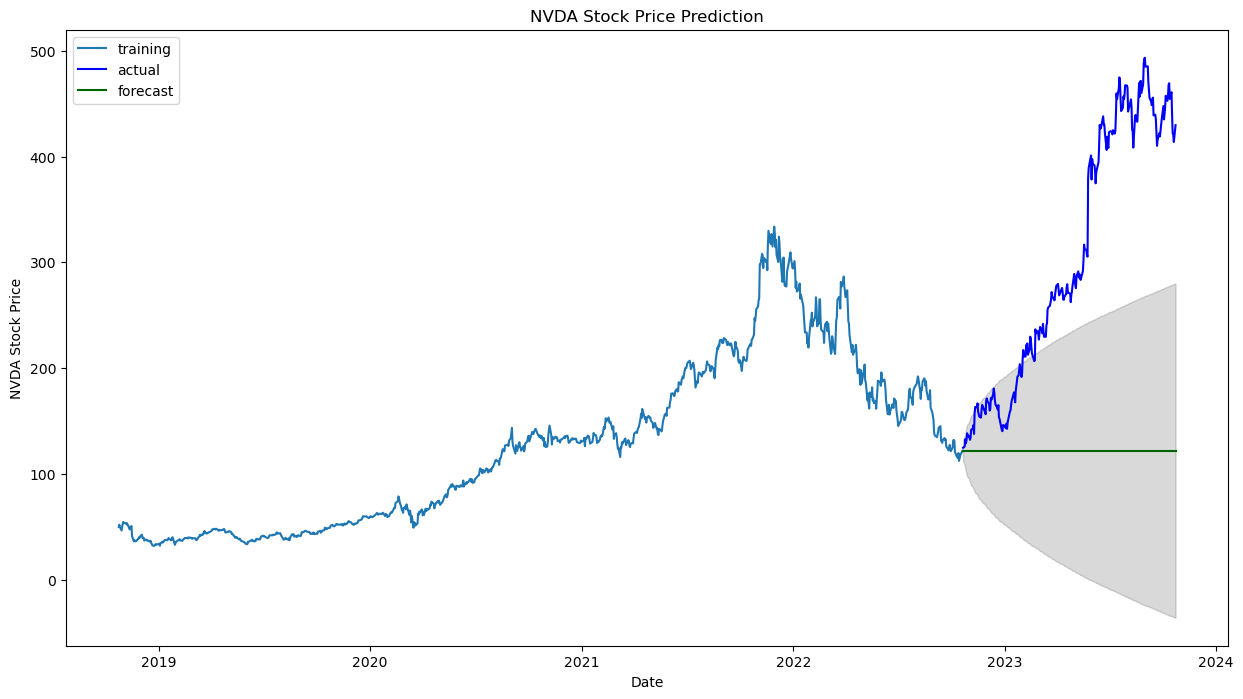

In [8]:
fitted, confint = ARIMA_model.predict(n_periods=len(test_set), return_conf_int=True)
print(fitted)
#index_of_fc = pd.date_range(test_set.index[0], periods=len(test_set), freq='D')

# make series for plotting purpose
#fitted_series = pd.Series(data=fitted, index=test_set.index)
lower_series = pd.Series(confint[:, 0], index=test_set.index)
upper_series = pd.Series(confint[:, 1], index=test_set.index)
#print(fitted_series.head())
#plot
plt.figure(figsize=(15,8))
plt.plot(train_set['Close'], label='training')
plt.plot(test_set['Close'], color='blue', label='actual')
plt.plot(test_set.index, fitted, color='darkgreen', label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.show()

While it does not seem too good, I will keep it as it is for now..... (I think the surge in price might be due to non-price factors)
<p>Now we will try to fit the model to the entire dataset and predict the stock prices for the next 12 days

In [9]:
ARIMA_model = pm.auto_arima(df['Close'], 
                      start_p=2, 
                      start_q=10,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=15, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      start_P=0,
                      D=0,
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)


c:\Users\HCM\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HCM\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1257    430.052466
1258    430.354932
1259    430.657398
1260    430.959865
1261    431.262331
1262    431.564797
1263    431.867263
1264    432.169729
1265    432.472195
1266    432.774662
1267    433.077128
1268    433.379594
dtype: float64


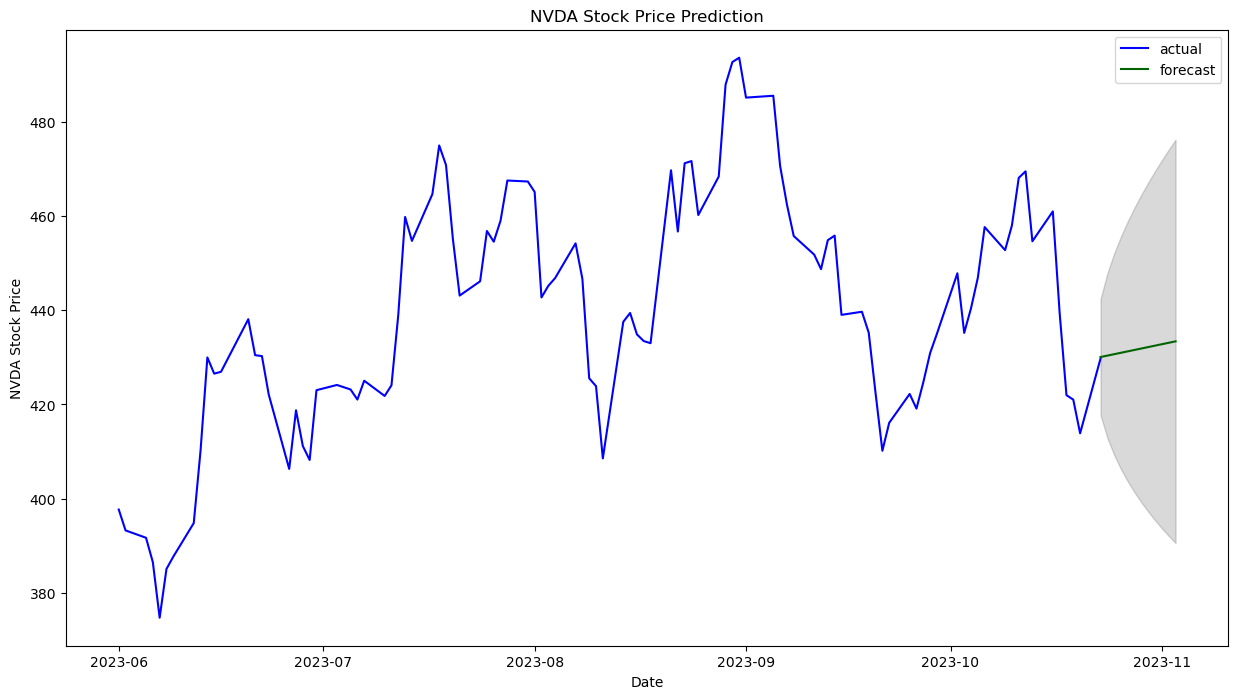

In [10]:
index_of_fc = pd.date_range(df.index[-1], periods = 12, freq='D')
forecast, confint = ARIMA_model.predict(n_periods=12, return_conf_int=True)
print(forecast)
prediction = pd.DataFrame(forecast[1:-1], columns=['Close'])
prediction.reset_index(drop=True, inplace=True)
prediction.to_csv('ARIMA_prediction.csv')


# make series for plotting purpose
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
#plot
plt.figure(figsize=(15,8))
plt.plot(df[-100:]['Close'], color='blue', label='actual')
plt.plot(index_of_fc, forecast, color='darkgreen', label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.show()
